# autograd & Logistic Regression
本节对pytorch的自动求导系统中常用的两个方法torch.autograd.backward和torch.autograd.grad进行介绍，并演示一阶导数，二阶导数的求导过程；      

理解了自动求导系统，以及数据载体——张量，前向传播构建计算图，计算图求取梯度过程，这些知识之后，就可以开始正式训练机器学习模型。这里通过演示逻辑回归模型的训练，学习机器学习回归模型的五大模块：数据、模型、损失函数、优化器和迭代训练过程。    

这五大模块将是后面学习的主线。
## 1. autograd-自动求导系统
### 1.1 torch.autograd.backward
功能: <font color=red>自动求取梯度</font>
- tensor: 用于求导的张量，如loss
- retain_graph: 保存计算图
- create_graph: 创建导数计算图，用于高阶求导
- grad_tensors: 多梯度权重

继续上节课的例子，$y = (x+w)*(w+1)$，$x=2, w=1$

In [1]:
# ==================== retain_graph ==========================
import torch

w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

# 这里的类方法和函数 backward(tensor=self)是一致的，可以通过调试查看到
y.backward(retain_graph= True)
print(w.grad)

tensor([5.])


In [2]:
# 若想求两次梯度，需要让第一次的求梯度 retain_graph，会累加上次的梯度
y.backward()
print(w.grad)

tensor([10.])


In [3]:
# ====================== grad_tensors ==========================
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)     # retain_grad()
b = torch.add(w, 1)

y0 = torch.mul(a, b)    # y0 = (x+w) * (w+1)
y1 = torch.add(a, b)    # y1 = (x+w) + (w+1)    dy1/dw = 2

loss = torch.cat([y0, y1], dim=0)       # [y0, y1]

# 按照grad_tensors中的权重[1,2]分别计算loss中y0,y1的梯度，再求和
grad_tensors = torch.tensor([1., 2.])

loss.backward(gradient=grad_tensors)    # gradient 传入 torch.autograd.backward()中的grad_tensors

# dy0/dw = 5; dy1/dw = 2
print(w.grad)

tensor([9.])


### 1.2 torch.autograd.grad
功能: <font color=red>求取梯度</font>
- outputs: 用于求导的张量，如loss
- inputs: 需要梯度的张量
- retain_graph: 保存计算图
- create_graph: 创建导数计算图，用于高阶求导
- grad_tensors: 多梯度权重



In [4]:
x = torch.tensor([3.], requires_grad=True)
y = torch.pow(x, 2) # y = xˆ2

# grad_1 = dy/dx = 2x = 2*3 = 6 
grad_1 = torch.autograd.grad(y, x, create_graph=True)
print(grad_1)

# grad_2 = d(dy/dx)/dx = d(2x)/dx = 2
grad_2 = torch.autograd.grad(grad_1[0], x)
print(grad_2)

(tensor([6.], grad_fn=<MulBackward0>),)
(tensor([2.]),)


### 1.3 autograd 要注意的细节
1. 梯度不会自动清零
2. 依赖于叶子结点的结点，requires_grad默认为True
3. 叶子结点不可执行in-place

#### 1.3.1 梯度不会自动清零

In [5]:
# 不设置，梯度会累加
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

for i in range(4):
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)

    y.backward()
    print(w.grad)

tensor([5.])
tensor([10.])
tensor([15.])
tensor([20.])


In [6]:
# 设置grad.zero_()，每次计算后自动将梯度清零，而从不会产生累加
# zero_()其中下划线表示，in-place操作
w.grad.zero_()
for i in range(4):
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)

    y.backward()
    print(w.grad)
    w.grad.zero_()

tensor([5.])
tensor([5.])
tensor([5.])
tensor([5.])


#### 1.3.2 依赖于叶子结点的结点，requires_grad默认为True

In [7]:
print(a.requires_grad, b.requires_grad, y.requires_grad)

True True True


#### 1.3.3 叶子结点不可执行in-place
- why: 在计算图中，已经记录了叶子结点的地址，需要它的值去计算非叶子结点的梯度，不能再改变它的值

In [9]:
# w.add_(1)
# RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.

In [10]:
a = torch.ones((1, ))
print(id(a), a)

a += torch.ones((1, ))
print(id(a), a)

4545288520 tensor([1.])
4545288520 tensor([2.])


In [12]:
a = torch.ones((1, ))
print(id(a), a)

# 开辟了新的内存地址，不是in-place操作
a = a + torch.ones((1, ))
print(id(a), a)

4545373744 tensor([1.])
4887754288 tensor([2.])


## 2. 逻辑回归
逻辑回归是<font color=red>线性</font>的<font color=red>二分类</font>模型    
模型表达式:
$$ y = f(WX + b)$$
$$ = \frac{1}{1+e^{-(WX+b)}}$$

$$f(x) = \frac{1}{1+e^{-x}} $$
f(x)称为Sigmoid函数，也称为Logistic函数
$$ class=\left\{
\begin{aligned}
0 &, 0.5>y&  \\
1 &, 0.5\leq y& \\
\end{aligned}
\right.
$$

- 线性回归是分析<font color=red>自变量x</font>与<font color=red>因变量y(标量)</font>之间关系的方法    
- 逻辑回归是分析<font color=red>自变量x</font>与<font color=red>因变量y(概率)</font>之间关系的方法

### 2.1 对数几率回归
$$ln{\frac{y}{1-y}} = WX+b$$

$$\frac{y}{1-y} = e^{WX+b}$$

$$y = e^{WX+b} - y*e^{WX+b}$$

$$y(1+e^{WX+b})=e^{WX+b}$$

$$y = \frac{e^{WX+b}}{1+e^{WX+b}}=\frac{1}{1+e^{-(WX+b)}}$$

### 2.2 线性回归
- 自变量:X 
- 因变量:y
- 关系: $y = 𝑊𝑋 + 𝑏$

### 2.3 对数回归
$lny = 𝑊𝑋+𝑏$

## 3. 机器学习模型训练步骤

[数据---模型---损失函数---优化器] 迭代训练
![机器学习训练步骤](picture/机器学习训练步骤.png)

- 数据: <font color=blue>包含数据预处理，数据清洗分割，使得数据可以直接输送到模型中 x</font>  

- 模型: <font color=blue>根据具体的任务选择不同的模型，从线性回归到神经网络</font> 

- 损失函数: <font color=blue>根据具体的任务选择，比如在线性回归中选择MSE(均方差)，分类问题中选择交叉熵(cross entropy)</font> 

- 优化器: <font color=blue>有了loss，就可以求去梯度，然后就可以选择不同的优化器去更新参数</font> 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1.])


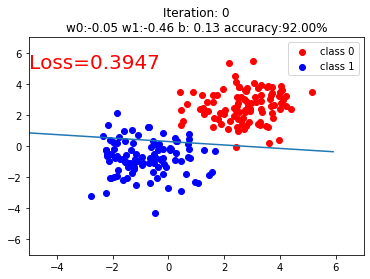

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
        1., 1.])


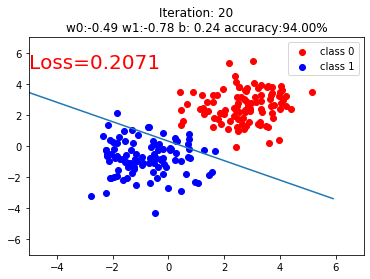

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
        1., 1.])


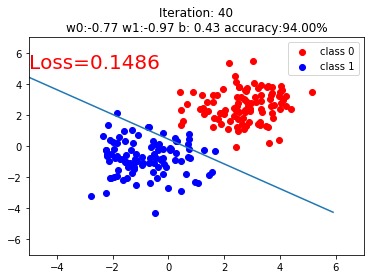

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 1.])


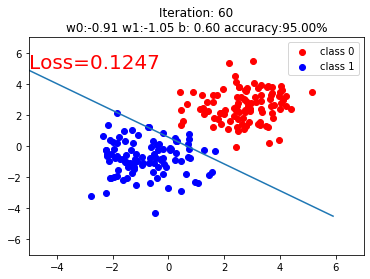

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 1.])


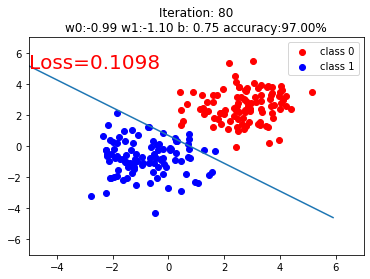

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 1.])


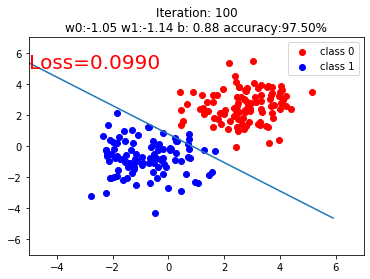

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 1.])


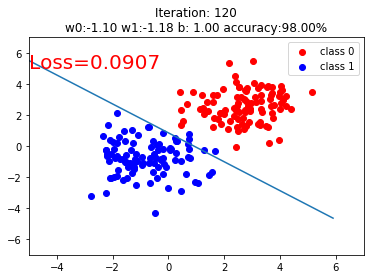

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 1.])


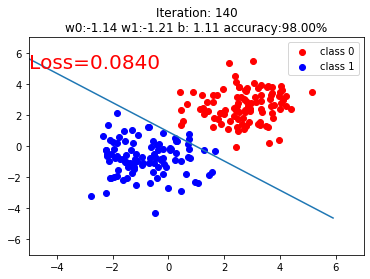

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1.])


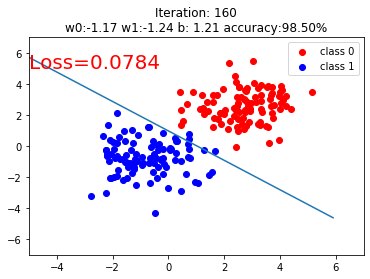

In [25]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

# ============================ step 1/5 生成数据 ============================
sample_nums = 100
mean_value = 1.7
bias = 1
n_data = torch.ones(sample_nums, 2)
x0 = torch.normal(mean_value * n_data, 1) + bias      # 类别0 数据 shape=(100, 2)
y0 = torch.zeros(sample_nums)                         # 类别0 标签 shape=(100, 1)
x1 = torch.normal(-mean_value * n_data, 1) + bias     # 类别1 数据 shape=(100, 2)
y1 = torch.ones(sample_nums)                          # 类别1 标签 shape=(100, 1)
train_x = torch.cat((x0, x1), 0)
train_y = torch.cat((y0, y1), 0)

# ============================ step 2/5 选择模型 ============================
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.features = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x


lr_net = LR()   # 实例化逻辑回归模型

# ============================ step 3/5 选择损失函数 ============================
loss_fn = nn.BCELoss()

# ============================ step 4/5 选择优化器   ============================
lr = 0.01  # 学习率
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

# ============================ step 5/5 模型训练 ============================
for iteration in range(1000):

    # 前向传播
    y_pred = lr_net(train_x)

    # 计算 loss
    loss = loss_fn(y_pred.squeeze(), train_y)

    # 反向传播
    loss.backward()

    # 更新参数
    optimizer.step()

    # 清空梯度
    optimizer.zero_grad()

    # 绘图
    if iteration % 20 == 0:

        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()  # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)  # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()

        plt.show()
        plt.pause(0.1)

        if acc > 0.98:
            break

torch.Size([200])